# 1. Problem

## Abstract
The objective of this data is to understand customer demographics and buying behavior for an insurance company to determine the following:  
1. who are the most profitable customers  
2. which demographics are most correlated with larger total claim amounts  
3. which sales channels are most popular with these demographics  
4. what types of policies are popular within this demographic  

## The Data
The data collected represents sales data about different customers and their transactions with this insurance company.
Data has been collected on the following features:  
- Customer---                                           'Unique Customer ID'    
- State---                                              'U.S. State '  
- Customer Lifetime Value---                            'Total value of customer over duration of retention'  
- Response---                                           'Yes/No'  
- Coverage---                                           'Type of coverage'  
- Education---                                          'Educational background of the customer'   
- Effective To Date---                                  'Date of policy initiation'    
- EmploymentStatus---                                   'Customer Employment status'  
- Gender---                                             'Customer gender'   
- Income---                                             'Customer reported income'  
- Location Code---                                      'Customer location information'  
- Marital Status---                                     'Customer Marital Status'  
- Monthly Premium Auto---                               'Monthly payment on insurance premium'  
- Months Since Last Claim---                            'Number of months since a claim was last made'  
- Months Since Policy Inception---                      'Number of months since the start of last policy'   
- Number of Open Complaints---                          'Number of open complaints by customer'   
- Number of Policies---                                 'Number of Policies held by customer'   
- Policy Type---                                        'Type of policy held by customer'  
- Policy---                                             'Policy Option held by customer'  
- Renew Offer Type---                                   'Renewal Offers'  
- Sales Channel---                                      'Preferred sales channel'    
- Total Claim Amount---                                 'Total amount paid to customer for claims'       
- Vehicle Class---                                      'Class of vehicle for which the policy is held'      
- Vehicle Size---                                       'Size of vehicle for which the policy is held'       



In [34]:
#Import the necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import sklearn
from math import sqrt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

In [35]:
# Ensure all pd cells are viewable.
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None) 

# 2. Get Data  

Read data from marketing_customer_analysis.csv into a Pandas dataframe for cleaning and transformation.

In [36]:
#read the csv file into a pandas dataframe
customers = pd.read_csv('marketing_customer_analysis.csv')

# 3. Cleaning/Wrangling/EDA

- Change headers names.
- Deal with NaN values.
- Categorical Features.
- Numerical Features.
- Exploration.

In [37]:
#view column header and standardize headers
cols= [col.lower() for col in customers.columns]
cols[7] = 'employment status'

#update column headers
customers.columns = cols

## Define functions to streamline data cleaning

In [38]:
#define function to calculate percentage of NaNs in each column
def NaN_percenter(dataframe):
    null_df = pd.DataFrame(round(dataframe.isna().sum()/len(customers),4)*100)
    null_df = null_df.reset_index()
    null_df.columns = ['feature','PercentNaNs']
    return null_df

In [39]:
# define function to drop columns with NaNs over acceptable limit
def NaN_drop(dataframe, nan_limit = 30):
    nulls_dataframe = NaN_percenter(dataframe)
    to_drop = []
    indexp = 0
    for p in nulls_dataframe['PercentNaNs']:
        if p >= nan_limit:
            to_drop.append(nulls_dataframe['feature'][indexp])
        indexp +=1
    dataframe = dataframe.drop(to_drop, axis = 1)
    return dataframe

In [40]:
# define function to replace NaNs with mean values for columns with NaNs within defined limit
def NaN_replacer(dataframe, nan_limit = 10):
    nulls_dataframe = NaN_percenter(dataframe)
    to_replace = []
    indexp = 0
    for p in nulls_dataframe['PercentNaNs']:
        if p <= nan_limit:
            to_replace.append(nulls_dataframe['feature'][indexp])
        indexp +=1
    for column in dataframe.columns:
        if column in to_replace and (dataframe[column].dtype == 'int64' or dataframe[column].dtype == 'float64'):
                column_mean = dataframe[column].mean()
                column_mode = dataframe[column].mode()
                if dataframe[column].dtype == 'object':
                    dataframe[column] = dataframe[column].fillna(column_mode)
                else:
                    dataframe[column] = dataframe[column].fillna(column_mean)
        else:
            pass
    return dataframe

In [41]:
# define function to convert columns to appropriate numerical types.
def column_formatter(dataframe):            
    for column in dataframe:
        new_values = []
        for value in dataframe[column].values:
            if '%' in str(value):
                value = value[:-1]
                new_values.append(value)
            else:
                new_values.append(value)
        dataframe[column] = new_values

        try:
            dataframe[column] = pd.to_numeric(dataframe[column])
        except:
            continue
    for column in dataframe:
        if dataframe[column].dtype != 'object':
            dataframe[column] = round(dataframe[column], 2)
    return dataframe

In [42]:
#define function to create/update column for months    
def ym_extractor(dataframe, date):
    dataframe[date] = pd.to_datetime(dataframe[date])    
    dataframe['year'] = dataframe[date].dt.year
    dataframe['month'] = dataframe[date].dt.month 

    return dataframe

In [43]:
# define function to clean data:
def clean_customer_data(dataframe, nan_drop_limit, nan_drop_threshold):
    # format column datatypes
    df = column_formatter(dataframe)

    # drop NaN columns over limit
    df = NaN_drop(df, nan_drop_limit)
    
    # filter out empty rows based on unique id column
    df = df[df['customer'].isna() == False]

    # replace NaNs in columns within NaN limit
    df = NaN_replacer(df, nan_drop_threshold)

      # add/update month column
    df = ym_extractor(df, 'effective to date')

    # remove duplicate values
    df = df.drop_duplicates()

    return df
    

## Clean Data 
1. Drop columns with over 25% missing values
2. Replace columns with under 10% most common values 

In [44]:
# Clean data
customers = clean_customer_data(customers, 25,10)


## Separate features into numerical and categorical data.

In [45]:
# Create dataframe of customer numerical data
numericals = customers._get_numeric_data()
numericals.head()

customer lifetime value  income  monthly premium auto  \
0                  2763.52   56274                    69   
1                  6979.54       0                    94   
2                 12887.43   48767                   108   
3                  7645.86       0                   106   
4                  2813.69   43836                    73   

   months since last claim  months since policy inception  \
0                       32                              5   
1                       13                             42   
2                       18                             38   
3                       18                             65   
4                       12                             44   

   number of open complaints  number of policies  total claim amount  year  \
0                          0                   1              384.81  2011   
1                          0                   8             1131.46  2011   
2                          0                   2              566.47  2011   
3                          0                   7              529.88  2011   
4                          0                   1              138.13  2011   

   month  
0      2  
1      1  
2      2  
3      1  
4      2

In [46]:
# Create dataframe of customer categorical data
categoricals = customers.select_dtypes('object')
categoricals.head()

customer       state response  coverage education employment status gender  \
0  BU79786  Washington       No     Basic  Bachelor          Employed      F   
1  QZ44356     Arizona       No  Extended  Bachelor        Unemployed      F   
2  AI49188      Nevada       No   Premium  Bachelor          Employed      F   
3  WW63253  California       No     Basic  Bachelor        Unemployed      M   
4  HB64268  Washington       No     Basic  Bachelor          Employed      M   

  location code marital status     policy type        policy renew offer type  \
0      Suburban        Married  Corporate Auto  Corporate L3           Offer1   
1      Suburban         Single   Personal Auto   Personal L3           Offer3   
2      Suburban        Married   Personal Auto   Personal L3           Offer1   
3      Suburban        Married  Corporate Auto  Corporate L2           Offer1   
4         Rural         Single   Personal Auto   Personal L1           Offer1   

  sales channel  vehicle class vehicle size  
0         Agent   Two-Door Car      Medsize  
1         Agent  Four-Door Car      Medsize  
2         Agent   Two-Door Car      Medsize  
3   Call Center            SUV      Medsize  
4         Agent  Four-Door Car      Medsize

## Perform Exploratory Data Analysis
Visualize target data from numerical and categorical data  

# Numerical Data:

<Figure size 864x576 with 0 Axes>

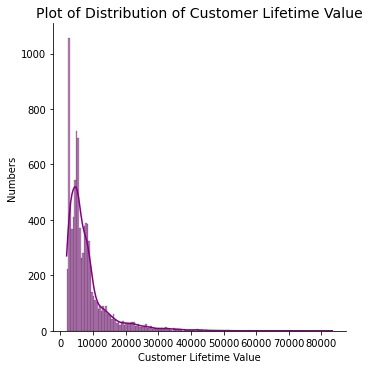

<Figure size 864x576 with 0 Axes>

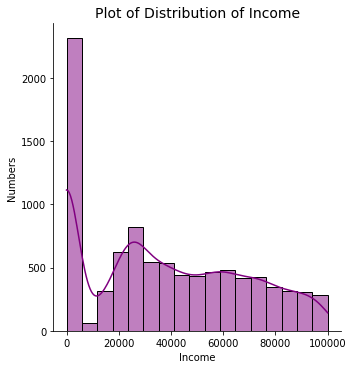

<Figure size 864x576 with 0 Axes>

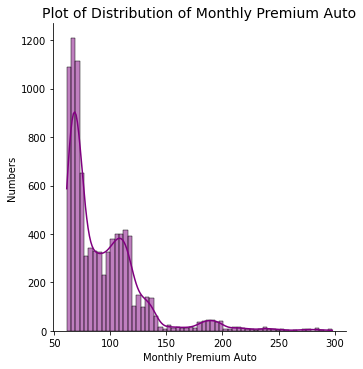

<Figure size 864x576 with 0 Axes>

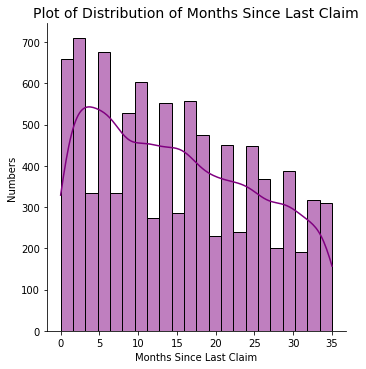

<Figure size 864x576 with 0 Axes>

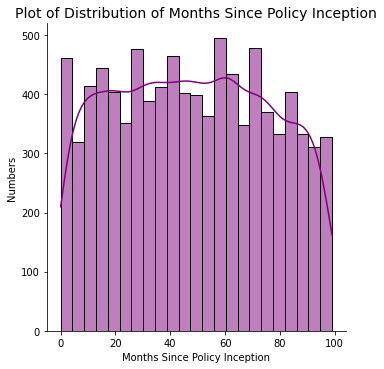

<Figure size 864x576 with 0 Axes>

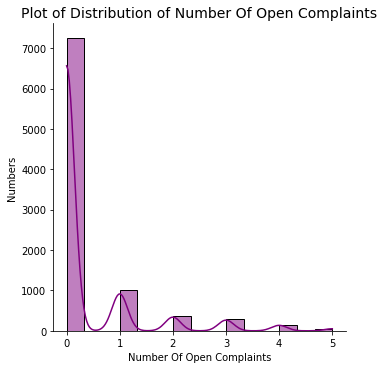

<Figure size 864x576 with 0 Axes>

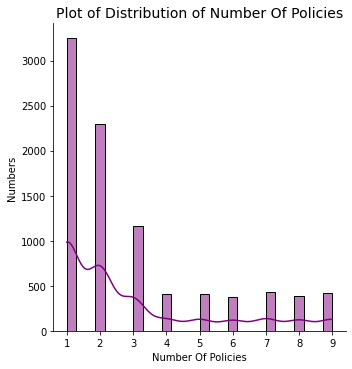

<Figure size 864x576 with 0 Axes>

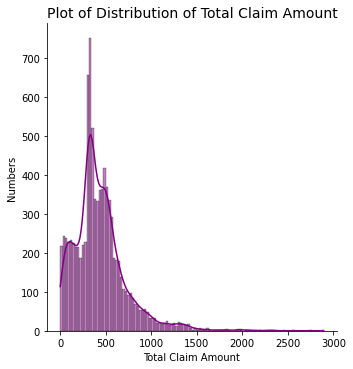

In [47]:
# Define function to produce histogram plots of numerical data

def numerical_visualizer(num_dataframe, feature):
    # define plot figure
    fig = plt.figure(figsize = (12,8))
    # define the type and styling of the plot
    sns.displot(num_dataframe[feature], kde = True, color = 'purple')
    plt.ylabel('Numbers')
    plt.xlabel(f'{feature.title()}')
    plt.title(f'Plot of Distribution of {feature.title()}', fontsize = 14)
    return plt.show()

# Run a for loop to plot all desired numerical features (month and year removed from selection)
for feature in numericals.columns[:-2]:
    if numericals[feature].dtype in ['int64', 'float64']:
        numerical_visualizer(numericals,feature)

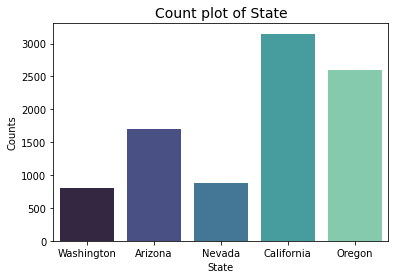

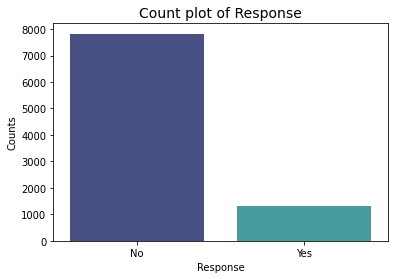

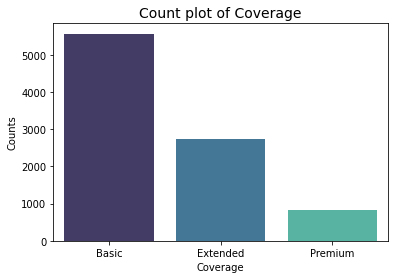

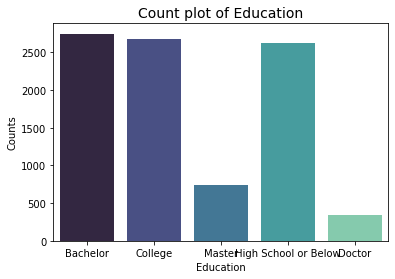

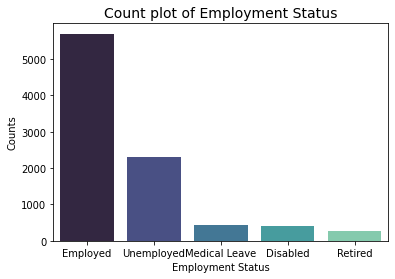

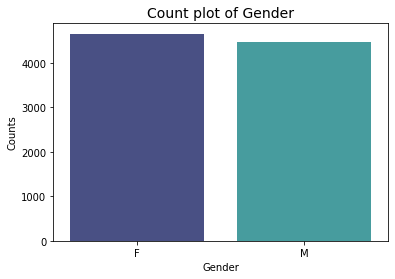

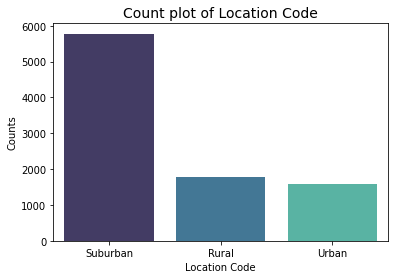

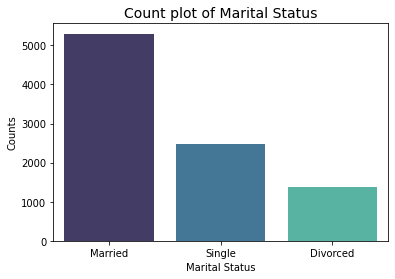

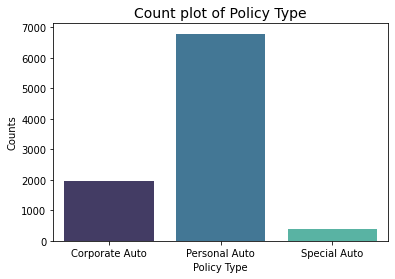

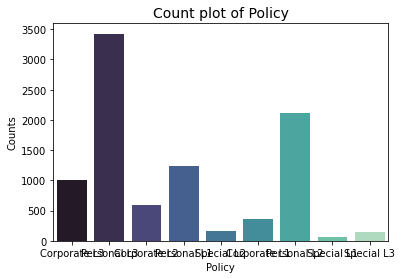

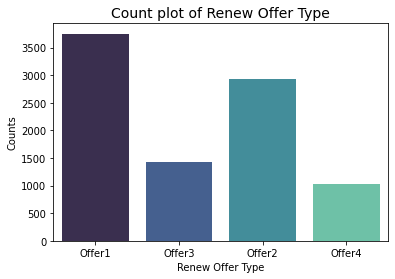

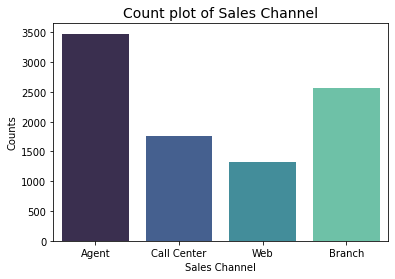

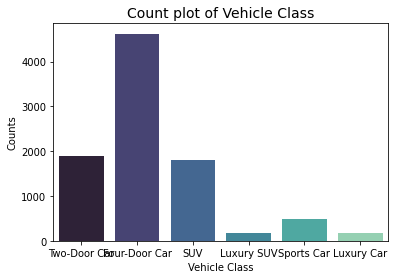

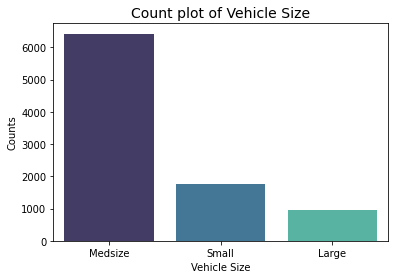

In [48]:
#define function to produce a plot of counts for categorical data.
def category_visualizer(cat_dataframe, feature):
    # define plot figure
    fig = plt.figsize = (12,8)
    # define the type and styling of plot
    sns.countplot(x = feature, data = cat_dataframe, palette = 'mako')
    plt.ylabel('Counts')
    plt.xlabel(f'{feature.title()}')
    plt.title(f'Count plot of {feature.title()}', fontsize = 14)
    return plt.show()

# Run loop to plot all categorical features.
for feature in categoricals.columns[1:]:
    category_visualizer(categoricals, feature)




## Additional Exploration of Customer Behavior and Trends
   
Investigate target indicators of customer profitability against categorical markers of customer demographics  
- customer lifetime value
- monthly premium auto
- total claim amount
- income

vs
- gender
- employment status
- marital statues
- location code
- policy type
- renewal offer type
- vehicle size

## Reduce outliers 
As seen in the plots of numerical data there is data that exists on a wide range with skews that extend to some extreme values.  
In order to reduce this skewing, apply a log transformation to rescale the distribution of the data.


In [49]:
# Define Log tranformation: reduce range of 0 - 100000 to a range of 0-5
def log_transformer(x):
    x = np.log10(x)
    if np.isfinite(x):
        return x
    else:
        return np.NaN # so that we can replace these values with means later using the .fillna() function.

# run loop to apply log_transformer on selected numerical features

customer_lifetime_value_log = pd.DataFrame(list(map(log_transformer, numericals['customer lifetime value'])), columns = ['customer lifetime value'])
monthly_premium_auto_log = pd.DataFrame(list(map(log_transformer, numericals['monthly premium auto'])), columns = ['monthly premium auto'])
total_claim_value_log = pd.DataFrame(list(map(log_transformer, numericals['total claim amount'])), columns = ['total claim amount'])
income_log = pd.DataFrame(list(map(log_transformer, numericals['income'])), columns = ['income'])

numericals_log = pd.concat([customer_lifetime_value_log, monthly_premium_auto_log, total_claim_value_log, income_log], axis = 1)


C:\Users\Ish\AppData\Local\Temp/ipykernel_26584/1001907205.py:3: RuntimeWarning: divide by zero encountered in log10
  x = np.log10(x)


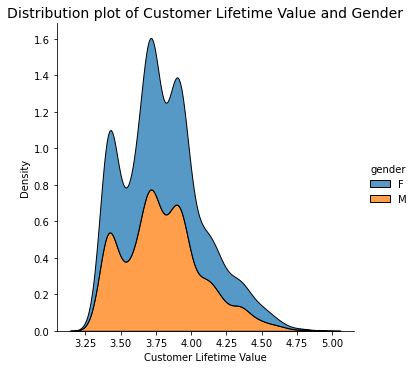

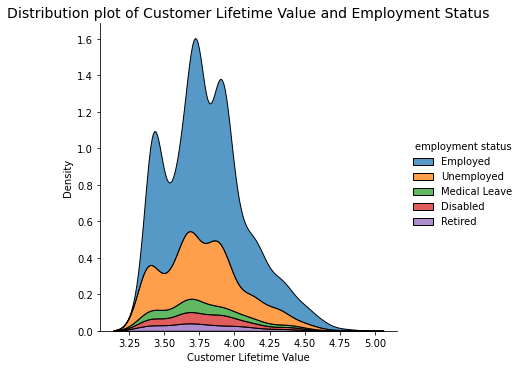

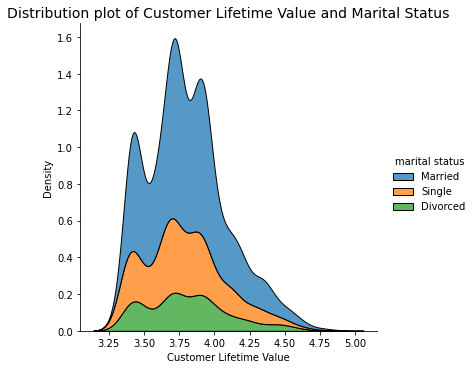

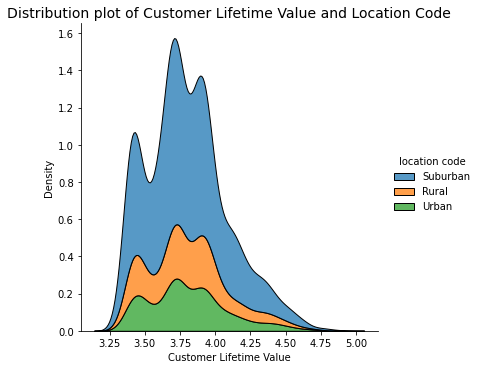

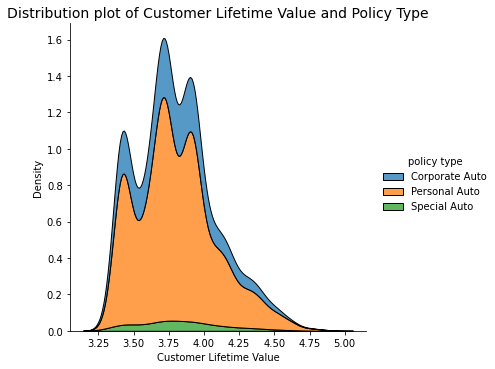

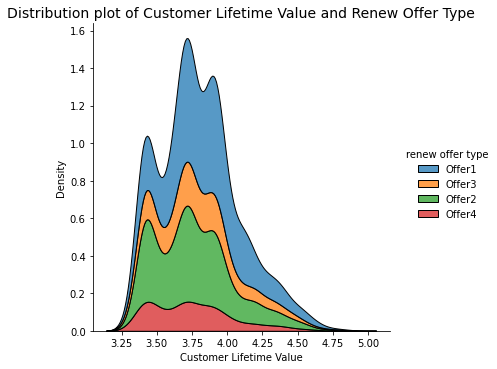

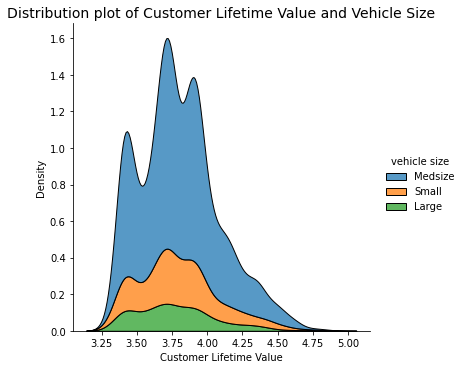

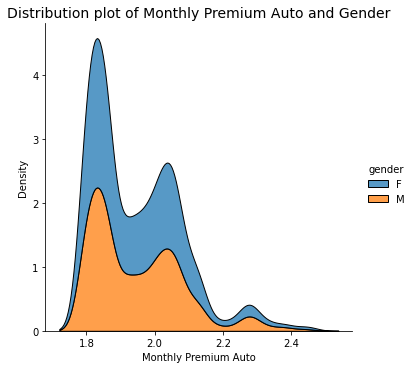

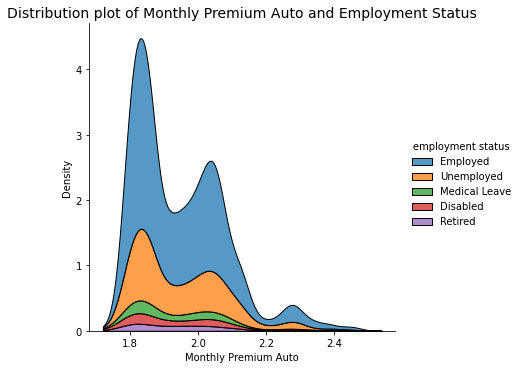

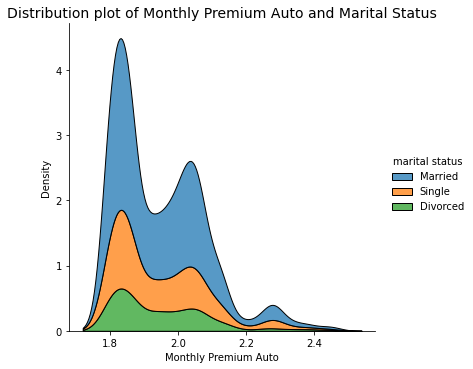

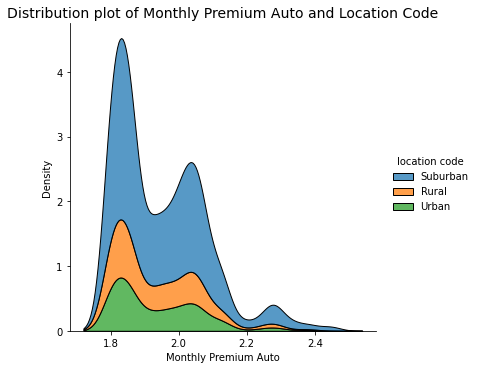

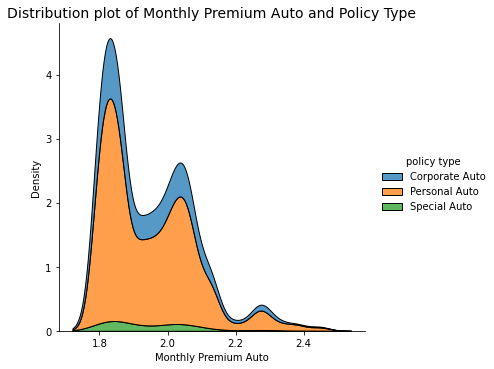

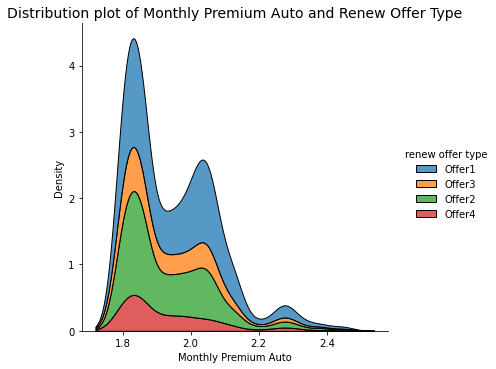

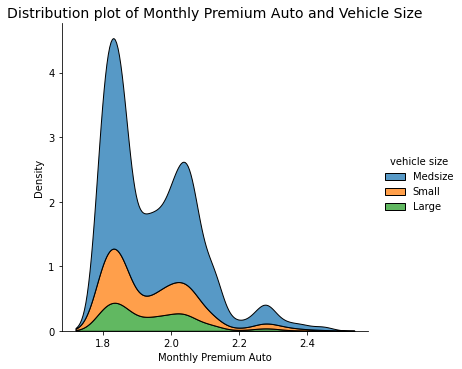

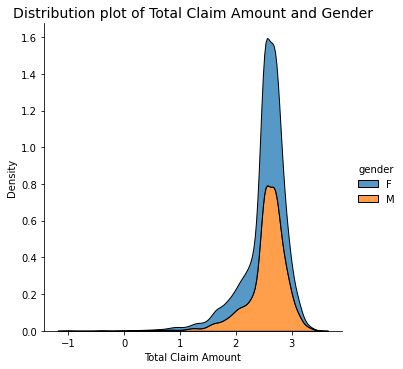

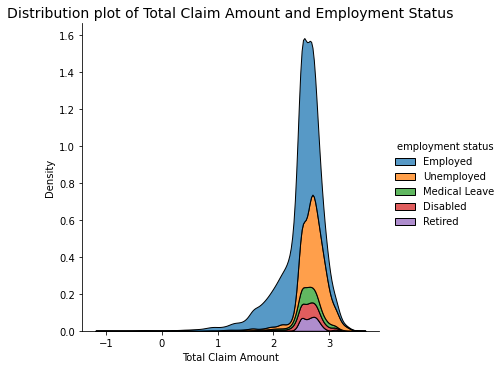

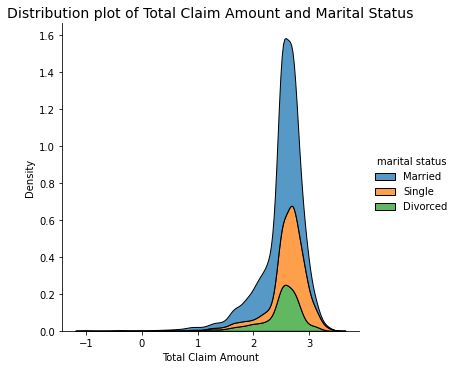

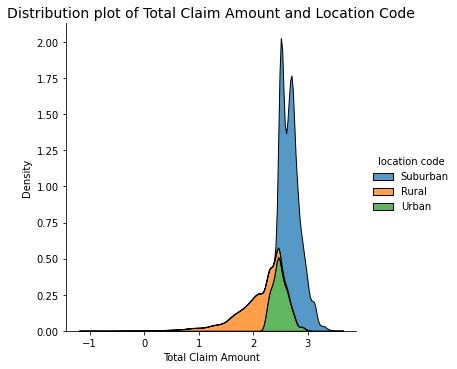

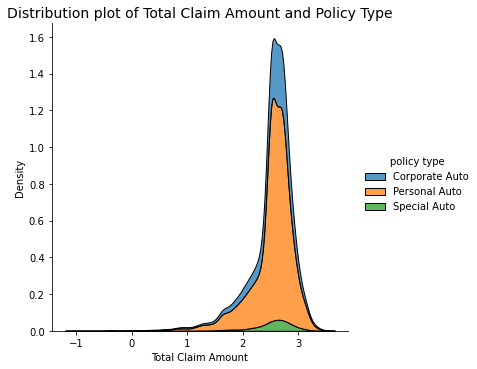

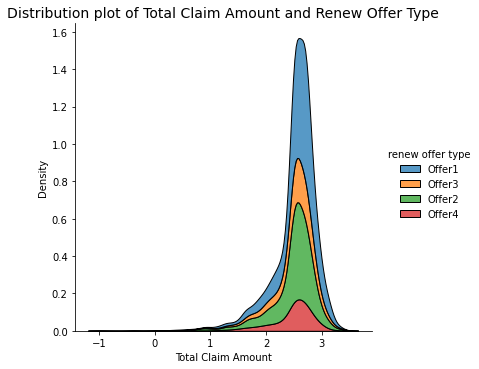

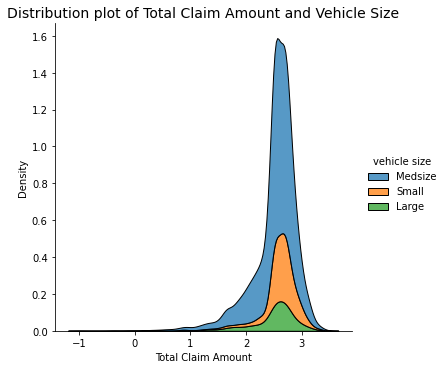

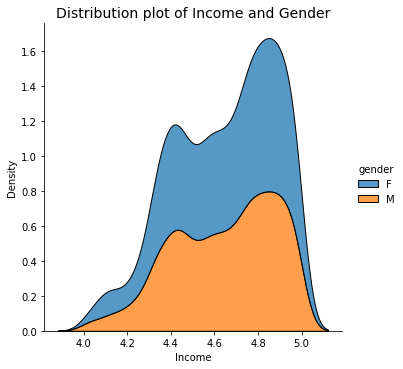

C:\Users\Ish\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


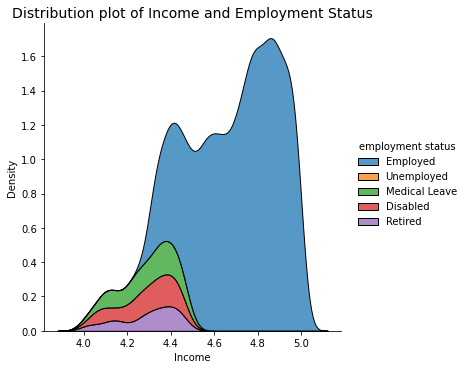

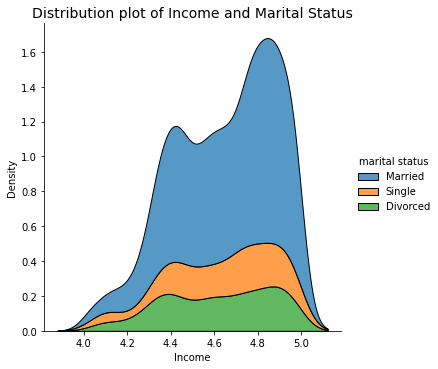

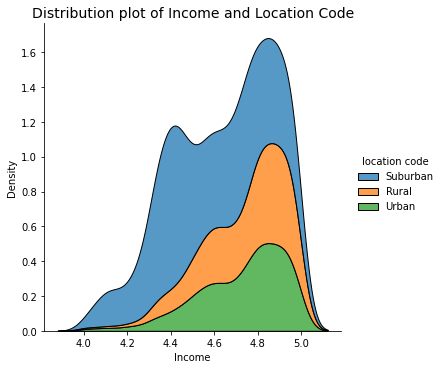

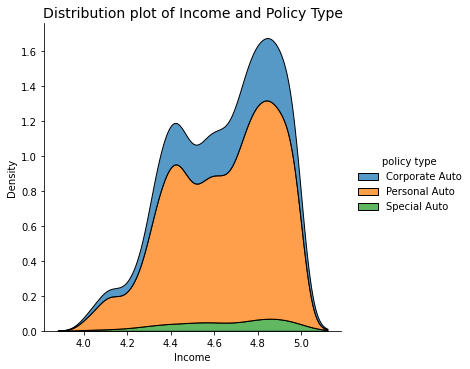

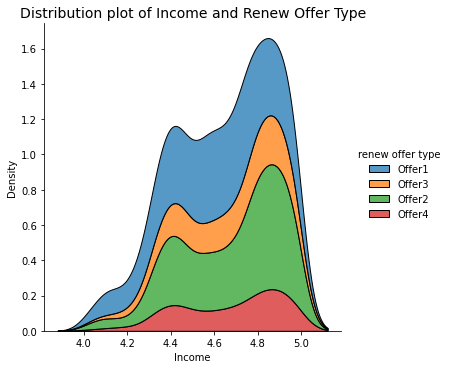

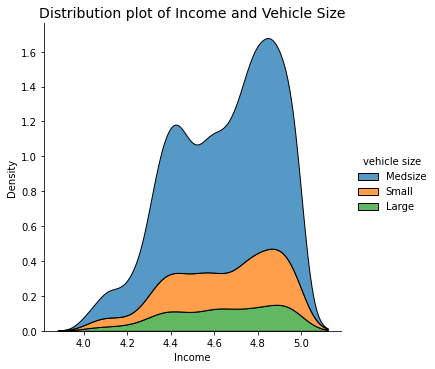

"\nfor feature in num_features:\n    comparative_visualizer(numericals, categoricals, feature, 'gender')\n    comparative_visualizer(numericals, categoricals, feature, 'employment status')\n    comparative_visualizer(numericals, categoricals, feature, 'marital status')\n    comparative_visualizer(numericals, categoricals, feature, 'location code')\n    comparative_visualizer(numericals, categoricals, feature, 'policy type')\n    comparative_visualizer(numericals, categoricals, feature, 'renew offer type')\n    comparative_visualizer(numericals, categoricals, feature, 'vehicle size')\n"

In [50]:
# define function to create plots for two features.
def comparative_visualizer(num_dataframe, cat_dataframe, feature1, feature2):
    # create a temporary concatenated dataframe.
    concat_dataframe = pd.concat([num_dataframe, cat_dataframe], axis = 1)
    # define plot figure
    fig = plt.figsize = (12,8)
    # define the type and styling of plot
    sns.displot(concat_dataframe, x=feature1, hue=feature2, kind= 'kde', multiple="stack")
    plt.ylabel('Density')
    plt.xlabel(f'{feature1.title()}')
    plt.title(f'Distribution plot of {feature1.title()} and {feature2.title()}', fontsize = 14)
    return plt.show()

# Run loop to plot desired comparisons
num_features = ['customer lifetime value', 'monthly premium auto', 'total claim amount', 'income']
for feature in num_features:
    comparative_visualizer(numericals_log, categoricals, feature, 'gender')
    comparative_visualizer(numericals_log, categoricals, feature, 'employment status')
    comparative_visualizer(numericals_log, categoricals, feature, 'marital status')
    comparative_visualizer(numericals_log, categoricals, feature, 'location code')
    comparative_visualizer(numericals_log, categoricals, feature, 'policy type')
    comparative_visualizer(numericals_log, categoricals, feature, 'renew offer type')
    comparative_visualizer(numericals_log, categoricals, feature, 'vehicle size')
'''
for feature in num_features:
    comparative_visualizer(numericals, categoricals, feature, 'gender')
    comparative_visualizer(numericals, categoricals, feature, 'employment status')
    comparative_visualizer(numericals, categoricals, feature, 'marital status')
    comparative_visualizer(numericals, categoricals, feature, 'location code')
    comparative_visualizer(numericals, categoricals, feature, 'policy type')
    comparative_visualizer(numericals, categoricals, feature, 'renew offer type')
    comparative_visualizer(numericals, categoricals, feature, 'vehicle size')
'''

# 4. Processing Data

- Dealing with outliers.
- Normalization.
- Encoding Categorical Data.
- Splitting into train set and test set.

## Use dataframe of consolidated categorical and numerical data.  

View dataframe statistical data to locate outliers.

In [72]:
customers.describe().T

count          mean           std      min  \
customer lifetime value        9134.0   8004.940473   6870.967599  1898.01   
income                         9134.0  37657.380009  30379.904734     0.00   
monthly premium auto           9134.0     93.219291     34.407967    61.00   
months since last claim        9134.0     15.097000     10.073257     0.00   
months since policy inception  9134.0     48.064594     27.905991     0.00   
number of open complaints      9134.0      0.384388      0.910384     0.00   
number of policies             9134.0      2.966170      2.390182     1.00   
total claim amount             9134.0    434.088834    290.500043     0.10   
year                           9134.0   2011.000000      0.000000  2011.00   
month                          9134.0      1.463762      0.498712     1.00   
customer profit                9134.0   7570.851639   6811.063512  1196.66   

                                   25%        50%         75%       max  
customer lifetime value        3994.25   5780.180   8962.1700  83325.38  
income                            0.00  33889.500  62320.0000  99981.00  
monthly premium auto             68.00     83.000    109.0000    298.00  
months since last claim           6.00     14.000     23.0000     35.00  
months since policy inception    24.00     48.000     71.0000     99.00  
number of open complaints         0.00      0.000      0.0000      5.00  
number of policies                1.00      2.000      4.0000      9.00  
total claim amount              272.26    383.945    547.5150   2893.24  
year                           2011.00   2011.000   2011.0000   2011.00  
month                             1.00      1.000      2.0000      2.00  
customer profit                3499.34   5437.525   8493.6075  82216.58

In [52]:
# separate features and labels from dataframe
X = customers.drop('total claim amount', axis = 1)
y = customers[['total claim amount']]


In [53]:
# split training data into numerical and categorical data for normalization and encoding
X_numericals = X._get_numeric_data()
X_categoricals = X.select_dtypes('object')


## Significant max values in 'customer lifetime value','income' and 'total claim amount' 
As there are significant outliers that may introduce skewing to the data it would be a good idea to normalize the  
data either by standardizing the data or by normalizing the data.

In [54]:
# standardize the data with StandardSCaler
StandardTransformer = StandardScaler().fit(X_numericals)
X_stands = pd.DataFrame(StandardTransformer.transform(X_numericals), columns = X_numericals.columns)
X_stands.head()

customer lifetime value    income  monthly premium auto  \
0                -0.762878  0.612827             -0.703925   
1                -0.149245 -1.239617              0.022691   
2                 0.710636  0.365710              0.429596   
3                -0.052263 -1.239617              0.371467   
4                -0.755575  0.203390             -0.587666   

   months since last claim  months since policy inception  \
0                 1.678099                      -1.543287   
1                -0.208186                      -0.217334   
2                 0.288205                      -0.360680   
3                 0.288205                       0.606907   
4                -0.307465                      -0.145661   

   number of open complaints  number of policies  year     month  \
0                   -0.42225           -0.822648   0.0  1.075304   
1                   -0.42225            2.106160   0.0 -0.929969   
2                   -0.42225           -0.404247   0.0  1.075304   
3                   -0.42225            1.687759   0.0 -0.929969   
4                   -0.42225           -0.822648   0.0  1.075304   

   customer profit  
0        -0.762352  
1        -0.252951  
2         0.697449  
3        -0.066788  
4        -0.718766

In [55]:
# normalize the data with MinMaxSCaler
MinMaxTransformer = MinMaxScaler().fit(X_numericals)
X_norms = pd.DataFrame(MinMaxTransformer.transform(X_numericals), columns = X_numericals.columns)
X_norms.head()

customer lifetime value    income  monthly premium auto  \
0                 0.010629  0.562847              0.033755   
1                 0.062406  0.000000              0.139241   
2                 0.134960  0.487763              0.198312   
3                 0.070589  0.000000              0.189873   
4                 0.011245  0.438443              0.050633   

   months since last claim  months since policy inception  \
0                 0.914286                       0.050505   
1                 0.371429                       0.424242   
2                 0.514286                       0.383838   
3                 0.514286                       0.656566   
4                 0.342857                       0.444444   

   number of open complaints  number of policies  year  month  customer profit  
0                        0.0               0.000   0.0    1.0         0.014590  
1                        0.0               0.875   0.0    0.0         0.057411  
2                        0.0               0.125   0.0    1.0         0.137303  
3                        0.0               0.750   0.0    0.0         0.073060  
4                        0.0               0.000   0.0    1.0         0.018254

In [56]:
# Encode categorical data with OneHot Encoder
# filter out features that have more than 5 categories.
drop_categories = []
for columns in X_categoricals:
    if len(X_categoricals[columns].value_counts()) > 5:
        drop_categories.append(columns)
X_categoricals = categoricals.drop(drop_categories, axis = 1)

In [57]:
# create encoder for OneHot encoding of features
# create encoder object
category_encoder = OneHotEncoder().fit(X_categoricals)

# create array of transformed categorical data
categories_encoded = category_encoder.transform(X_categoricals).toarray()

# create a loop to populate a list with appropriate category names as column headers
category_columns = []
for columns in category_encoder.categories_:
    for column_header in columns:
        category_columns.append(column_header)

# create a new dataframe from the array, with the appropriate header names
X_categoricals_coded = pd.DataFrame(categories_encoded, columns = category_columns)
X_categoricals_coded.head()

Arizona  California  Nevada  Oregon  Washington   No  Yes  Basic  Extended  \
0      0.0         0.0     0.0     0.0         1.0  1.0  0.0    1.0       0.0   
1      1.0         0.0     0.0     0.0         0.0  1.0  0.0    0.0       1.0   
2      0.0         0.0     1.0     0.0         0.0  1.0  0.0    0.0       0.0   
3      0.0         1.0     0.0     0.0         0.0  1.0  0.0    1.0       0.0   
4      0.0         0.0     0.0     0.0         1.0  1.0  0.0    1.0       0.0   

   Premium  Bachelor  College  Doctor  High School or Below  Master  Disabled  \
0      0.0       1.0      0.0     0.0                   0.0     0.0       0.0   
1      0.0       1.0      0.0     0.0                   0.0     0.0       0.0   
2      1.0       1.0      0.0     0.0                   0.0     0.0       0.0   
3      0.0       1.0      0.0     0.0                   0.0     0.0       0.0   
4      0.0       1.0      0.0     0.0                   0.0     0.0       0.0   

   Employed  Medical Leave  Retired  Unemployed    F    M  Rural  Suburban  \
0       1.0            0.0      0.0         0.0  1.0  0.0    0.0       1.0   
1       0.0            0.0      0.0         1.0  1.0  0.0    0.0       1.0   
2       1.0            0.0      0.0         0.0  1.0  0.0    0.0       1.0   
3       0.0            0.0      0.0         1.0  0.0  1.0    0.0       1.0   
4       1.0            0.0      0.0         0.0  0.0  1.0    1.0       0.0   

   Urban  Divorced  Married  Single  Corporate Auto  Personal Auto  \
0    0.0       0.0      1.0     0.0             1.0            0.0   
1    0.0       0.0      0.0     1.0             0.0            1.0   
2    0.0       0.0      1.0     0.0             0.0            1.0   
3    0.0       0.0      1.0     0.0             1.0            0.0   
4    0.0       0.0      0.0     1.0             0.0            1.0   

   Special Auto  Offer1  Offer2  Offer3  Offer4  Agent  Branch  Call Center  \
0           0.0     1.0     0.0     0.0     0.0    1.0     0.0          0.0   
1           0.0     0.0     0.0     1.0     0.0    1.0     0.0          0.0   
2           0.0     1.0     0.0     0.0     0.0    1.0     0.0          0.0   
3           0.0     1.0     0.0     0.0     0.0    0.0     0.0          1.0   
4           0.0     1.0     0.0     0.0     0.0    1.0     0.0          0.0   

   Web  Large  Medsize  Small  
0  0.0    0.0      1.0    0.0  
1  0.0    0.0      1.0    0.0  
2  0.0    0.0      1.0    0.0  
3  0.0    0.0      1.0    0.0  
4  0.0    0.0      1.0    0.0

In [65]:
# merge categorical and numerical data for training
X_normalized = pd.concat([X_numericals, X_categoricals_coded], axis = 1)

X_reduced = X_normalized[['customer lifetime value', 'income', 'monthly premium auto',
       'months since last claim', 'months since policy inception',
       'number of open complaints', 'number of policies','Arizona', 'California', 'Nevada', 'Oregon',
       'Washington', 'No', 'Yes', 'Basic', 'Extended', 'Premium', 'Bachelor',
       'College', 'Doctor', 'High School or Below', 'Master', 'Disabled',
       'Employed', 'Medical Leave', 'Retired', 'Unemployed', 'F', 'M', 'Rural',
       'Suburban', 'Urban', 'Divorced', 'Married', 'Single', 'Corporate Auto',
       'Personal Auto', 'Special Auto', 'Offer1', 'Offer2', 'Offer3', 'Offer4',
       'Agent', 'Branch', 'Call Center', 'Web', 'Large', 'Medsize', 'Small']]
X_reduced.head()

customer lifetime value  income  monthly premium auto  \
0                  2763.52   56274                    69   
1                  6979.54       0                    94   
2                 12887.43   48767                   108   
3                  7645.86       0                   106   
4                  2813.69   43836                    73   

   months since last claim  months since policy inception  \
0                       32                              5   
1                       13                             42   
2                       18                             38   
3                       18                             65   
4                       12                             44   

   number of open complaints  number of policies  Arizona  California  Nevada  \
0                          0                   1      0.0         0.0     0.0   
1                          0                   8      1.0         0.0     0.0   
2                          0                   2      0.0         0.0     1.0   
3                          0                   7      0.0         1.0     0.0   
4                          0                   1      0.0         0.0     0.0   

   Oregon  Washington   No  Yes  Basic  Extended  Premium  Bachelor  College  \
0     0.0         1.0  1.0  0.0    1.0       0.0      0.0       1.0      0.0   
1     0.0         0.0  1.0  0.0    0.0       1.0      0.0       1.0      0.0   
2     0.0         0.0  1.0  0.0    0.0       0.0      1.0       1.0      0.0   
3     0.0         0.0  1.0  0.0    1.0       0.0      0.0       1.0      0.0   
4     0.0         1.0  1.0  0.0    1.0       0.0      0.0       1.0      0.0   

   Doctor  High School or Below  Master  Disabled  Employed  Medical Leave  \
0     0.0                   0.0     0.0       0.0       1.0            0.0   
1     0.0                   0.0     0.0       0.0       0.0            0.0   
2     0.0                   0.0     0.0       0.0       1.0            0.0   
3     0.0                   0.0     0.0       0.0       0.0            0.0   
4     0.0                   0.0     0.0       0.0       1.0            0.0   

   Retired  Unemployed    F    M  Rural  Suburban  Urban  Divorced  Married  \
0      0.0         0.0  1.0  0.0    0.0       1.0    0.0       0.0      1.0   
1      0.0         1.0  1.0  0.0    0.0       1.0    0.0       0.0      0.0   
2      0.0         0.0  1.0  0.0    0.0       1.0    0.0       0.0      1.0   
3      0.0         1.0  0.0  1.0    0.0       1.0    0.0       0.0      1.0   
4      0.0         0.0  0.0  1.0    1.0       0.0    0.0       0.0      0.0   

   Single  Corporate Auto  Personal Auto  Special Auto  Offer1  Offer2  \
0     0.0             1.0            0.0           0.0     1.0     0.0   
1     1.0             0.0            1.0           0.0     0.0     0.0   
2     0.0             0.0            1.0           0.0     1.0     0.0   
3     0.0             1.0            0.0           0.0     1.0     0.0   
4     1.0             0.0            1.0           0.0     1.0     0.0   

   Offer3  Offer4  Agent  Branch  Call Center  Web  Large  Medsize  Small  
0     0.0     0.0    1.0     0.0          0.0  0.0    0.0      1.0    0.0  
1     1.0     0.0    1.0     0.0          0.0  0.0    0.0      1.0    0.0  
2     0.0     0.0    1.0     0.0          0.0  0.0    0.0      1.0    0.0  
3     0.0     0.0    0.0     0.0          1.0  0.0    0.0      1.0    0.0  
4     0.0     0.0    1.0     0.0          0.0  0.0    0.0      1.0    0.0

In [69]:
# Split data into training and testing sets with train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_reduced, y, test_size = 0.2, random_state= 100)

# 5 - Modeling

- Create and train model
- Apply model.



In [70]:
# Instantiate and train model on training data
Lr1 = LinearRegression()
Lr1.fit(X_train, y_train)

# make predictions
predicted_vals = Lr1.predict(X_train)

# validate model on training data
r2 = r2_score(y_train, predicted_vals)
mse = round(mean_squared_error(y_train, predicted_vals), 2)
rmse = round(sqrt(mean_squared_error(y_train, predicted_vals)), 2)
mae = round(mean_absolute_error(y_train, predicted_vals), 2)

print(r2)
print(mse)
print(rmse)
print(mae)

0.7711397327431144
19575.78
139.91
95.12


In [78]:
# Test model on testing data
test_predicted_vals = Lr1.predict(X_test)

# validate model on testing data
r2_test = r2_score(y_test,test_predicted_vals)
mse_test = round(mean_squared_error(y_test, test_predicted_vals), 2)
rmse_test = round(sqrt(mean_squared_error(y_test, test_predicted_vals)), 2)
mae_test = round(mean_absolute_error(y_test, test_predicted_vals), 2)

#print(f'Results of Model Performance:\nTraining Performance\nR2 Score:  {r2}\nMean Squared Error:  {mse}\nRoot Mean Squared Error:  {rmse}\nMean Absolute Error: {rmse}\n')
#print(f'Results of Model Performance:\nTesting Performance\nR2 Score:  {r2_test}\nMean Squared Error:  {mse_test}\nRoot Mean Squared Error:  {rmse}\nMean Absolute Error:  {mae_test}\n')

Results of Model Performance:
Training Performance
R2 Score:  0.7711397327431144
Mean Squared Error:  19575.78
Root Mean Squared Error:  139.91
Mean Absolute Error: 139.91

Results of Model Performance:
Testing Performance
R2 Score:  0.7703111650434837
Mean Squared Error:  18295.22
Root Mean Squared Error:  139.91
Mean Absolute Error:  95.97



# Report

## Results of Model Performance:  
### Training Performance  
-R2 Score:  0.7711397327431144  
-Mean Squared Error:  19575.78  
-Root Mean Squared Error:  139.91  
-Mean Absolute Error: 139.91  

## Results of Model Performance:  
### Testing Performance  
-R2 Score:  0.7703111650434837  
-Mean Squared Error:  18295.22  
-Root Mean Squared Error:  139.91  
-Mean Absolute Error:  95.97  